# Convolutional Autoencoder for Neural Segmentation

This is my implementation for the ISBI Challenge: Segmentation of neuronal structures in EM stacks. This is a challenge which can be found on the website of Dr. Seung's Lab at Princton http://seunglab.org/ or directly at http://brainiac2.mit.edu/isbi_challenge/ . 

## The Challenge

I will provide some information from the website about the challenge directly in this notebook. Please feel free to only read what seems important to you.

### Background and set-up
In this challenge, a full stack of EM slices will be used to train machine learning algorithms for the purpose of automatic segmentation of neural structures. The images are representative of actual images in the real-world, containing some noise and small image alignment errors. None of these problems led to any difficulties in the manual labeling of each element in the image stack by an expert human neuroanatomist. The aim of the challenge is to compare and rank the different competing methods based on their pixel and object classification accuracy.

### Training data
Training dataInput training data and corresponding labels.
The training data is a set of 30 sections from a serial section Transmission Electron Microscopy (ssTEM) data set of the Drosophila first instar larva ventral nerve cord (VNC). The microcube measures 2 x 2 x 1.5 microns approx., with a resolution of 4x4x50 nm/pixel.

The corresponding binary labels are provided in an in-out fashion, i.e. white for the pixels of segmented objects and black for the rest of pixels (which correspond mostly to membranes).

To get the training data, please, register, log in and go to the "Downloads" section.

This is the only data that participants are allowed to use to train their algorithms.

### Test data
The contesting segmentation methods will be ranked by their performance on a test dataset, also available under "downloads", after registration. This test data is another volume from the same Drosophila first instar larva VNC as the training dataset.

### Results format
The results are expected to be submitted as a 32-bit TIFF 3D image, which values between 0 (100% membrane certainty) and 1 (100% non-membrane certainty).

## Data Preprocessing

The data is read from three different .tif files and stored as numpy arrays. I needed to do some preprocessing before passing them to tensorflow. In particular, I've normalized the data, put it in batches and reshaped it so it could be passed to tensorflow.

In [1]:
# Import dependencies
from skimage import io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data
train_volume = io.imread('Data/train-volume.tif')
train_labels = io.imread('Data/train-labels.tif')
test_volume = io.imread('Data/test-volume.tif')

In [3]:
# Normalize function
def normalize(x):
    x = x.astype(np.float32)
    x /=255
    return x

In [4]:
# Normalize data
train_volume = normalize(train_volume)
train_labels = normalize(train_labels)
test_volume = normalize(test_volume)

In [5]:
# Create batches

# The data is currently a multidimensional numpy array (ndarray) with 3 dimensions. It has the shape 30 * 512 * 512, which
# means that the data exists of 30 greyscale pictures with dimension 512 pixels on 512 pixels. We want to make 30 batches of 1 
# picture each. We'll also have to reshape the data to pass it to convolutional layers in tensorflow (4 dimensions required).

def get_batches(data):
    data = np.reshape(data, (30, 512, 512, 1))
    data = np.split(data, 30)
    return data

In [6]:
# Batch data
volume_batches = get_batches(train_volume)
labels_batches = get_batches(train_labels)
test_batches = get_batches(test_volume)

## Data visualisation

Here I have plotted an example of picture to train on and of a picture which will serve as a label. Here you can see nicely how a electron microscopy picutre was mapped by a neuroscientist. This takes a lot of time and it would be beneficial if we were able to automate it. To watch different pictures change the values of volume_batches[i] and labels_batches[i].

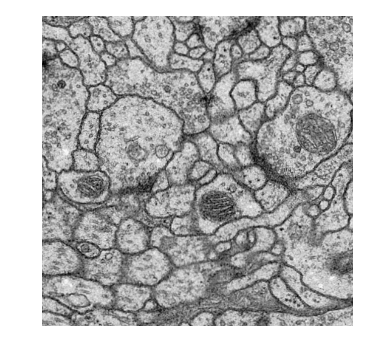

In [7]:
plt.axis('off')
plt.imshow(volume_batches[1].reshape(512,512), cmap='Greys_r')

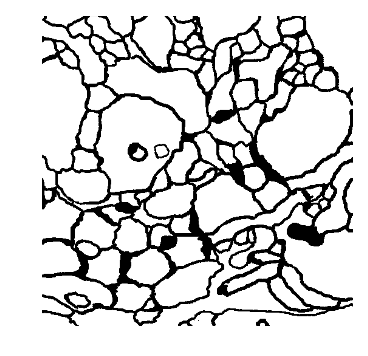

In [8]:
plt.axis('off')
plt.imshow(labels_batches[1].reshape(512,512), cmap='Greys_r')

## Model

Here I've constructed the actual convolutional autoencoder. Normally an autoencoder is used for data compression or denoising. The idea is that one neural net is the encoder and learns to map feautres of the data more efficiently. Then there is a second neural net, the decoder, which learns to map this compressed representation to data of the same resolution than the input data. If you try to minimalize the difference between the input and output, the two networks will optimize and become a relativly good data compression algorithm. When doing this with images you can use CNN because they typically perform better.

I have modified this architecture a bit to fit to my needs. I have used a CNN as the 'encoder' layer and let the CNN learn important features for itself during the convolutions. Then I used a deconvolutional layer as the 'decoder', but instead of minimizing the difference between the input and the output, I have set up the loss as to minimize the difference between the output and the labels. 

I hope that by the neural nets this way, that the convolutional layer learns to decide which are the relevant features in the electron microscopy sample, and that the deconvolutional layer learns to map from this representation of useful features to a good approximation of the labeling of the neuroscientist. 

In [9]:
# Construct a convolutional autoencoder

# Create placeholders
x = tf.placeholder(dtype = tf.float32, shape=(None, 512, 512, 1), name='x')
y = tf.placeholder(dtype = tf.float32, shape=(None, 512, 512, 1), name='y')

### Encoder
conv1 = tf.layers.conv2d(x, 32, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 512x512x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='same')
# Now 256x256x32
conv2 = tf.layers.conv2d(maxpool1, 64, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 256x256x64
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='same')
# Now 128x128x64
conv3 = tf.layers.conv2d(maxpool2, 128, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 128x128x128
    
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='same')
# Now 64x64x128
    
### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (64,64))
# Now 64x64x128
conv5 = tf.layers.conv2d(upsample1, 128, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 64x64x128
upsample2 = tf.image.resize_nearest_neighbor(conv5, (128,128))
# Now 128x128x128
conv6 = tf.layers.conv2d(upsample2, 64, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 128x128x64
upsample3 = tf.image.resize_nearest_neighbor(conv6, (256,256))
# Now 256x256x64
conv7 = tf.layers.conv2d(upsample3, 32, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 256x256x32
upsample4 = tf.image.resize_nearest_neighbor(conv7, (512,512))
# Now 512x512x32
    
logits = tf.layers.conv2d(upsample4, 1, (3,3), strides=(1,1), padding='same', activation=None)
# Now 512x512x1
    
decoded = tf.sigmoid(logits, name='decoded')

# Loss and Optimizer
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
cost = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

In [12]:
# Function for training the Neural Network
def train_neural_network(session, optimizer, feature_batch, label_batch):
    session.run(optimizer, feed_dict = {x: feature_batch, y: label_batch})

# Function for showing the stats
def print_stats(session, feature_batch, label_batch, cost):
    print("cost: ", session.run(cost, feed_dict = {x: feature_batch, y: label_batch}))

# Hyperparameters
epochs = 10
batch_size = 1

### Train Model

# Create the session
sess = tf.Session()

# Initializing the variables
sess.run(tf.global_variables_initializer())
    
# Training cycle
for epoch in range(epochs):
    n_batches = 30
    for i in range(0, n_batches):
        train_neural_network(sess, optimizer, volume_batches[i], labels_batches[i])
        print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, i), end='')
        print_stats(sess, volume_batches[i], labels_batches[i], cost)

Epoch  1, Batch 0:  cost:  0.644987
Epoch  1, Batch 1:  cost:  0.569468
Epoch  1, Batch 2:  cost:  0.590205
Epoch  1, Batch 3:  cost:  0.56432
Epoch  1, Batch 4:  cost:  0.567914
Epoch  1, Batch 5:  cost:  0.579454
Epoch  1, Batch 6:  cost:  0.558134
Epoch  1, Batch 7:  cost:  0.558764
Epoch  1, Batch 8:  cost:  0.543531
Epoch  1, Batch 9:  cost:  0.528475
Epoch  1, Batch 10:  cost:  0.552975
Epoch  1, Batch 11:  cost:  0.534203
Epoch  1, Batch 12:  cost:  0.554637
Epoch  1, Batch 13:  cost:  0.507072
Epoch  1, Batch 14:  cost:  0.474953
Epoch  1, Batch 15:  cost:  0.495922
Epoch  1, Batch 16:  cost:  0.491118
Epoch  1, Batch 17:  cost:  0.51847
Epoch  1, Batch 18:  cost:  0.482795
Epoch  1, Batch 19:  cost:  0.513054
Epoch  1, Batch 20:  cost:  0.51806
Epoch  1, Batch 21:  cost:  0.495758
Epoch  1, Batch 22:  cost:  0.494426
Epoch  1, Batch 23:  cost:  0.490913
Epoch  1, Batch 24:  cost:  0.470715
Epoch  1, Batch 25:  cost:  0.487871
Epoch  1, Batch 26:  cost:  0.496716
Epoch  1, Batc

## Visualizing result

Here I have tried to visualize the result. Above is the actual labeling done by a neuroscientist, underneath is the reconstruction of my model. Because there are no labels for the test set in the data, it is difficult to know whether the model overfits or not. You can leave some of the training samples out while training and compare the output they give after training the network and it still looks quit good. I'm no specialist in the field and have absolutely no idea whether this result is any good or if it is useful. I came up with the idea for this architecture myself but do not know if it already exist or anyone has come up with it way before me.

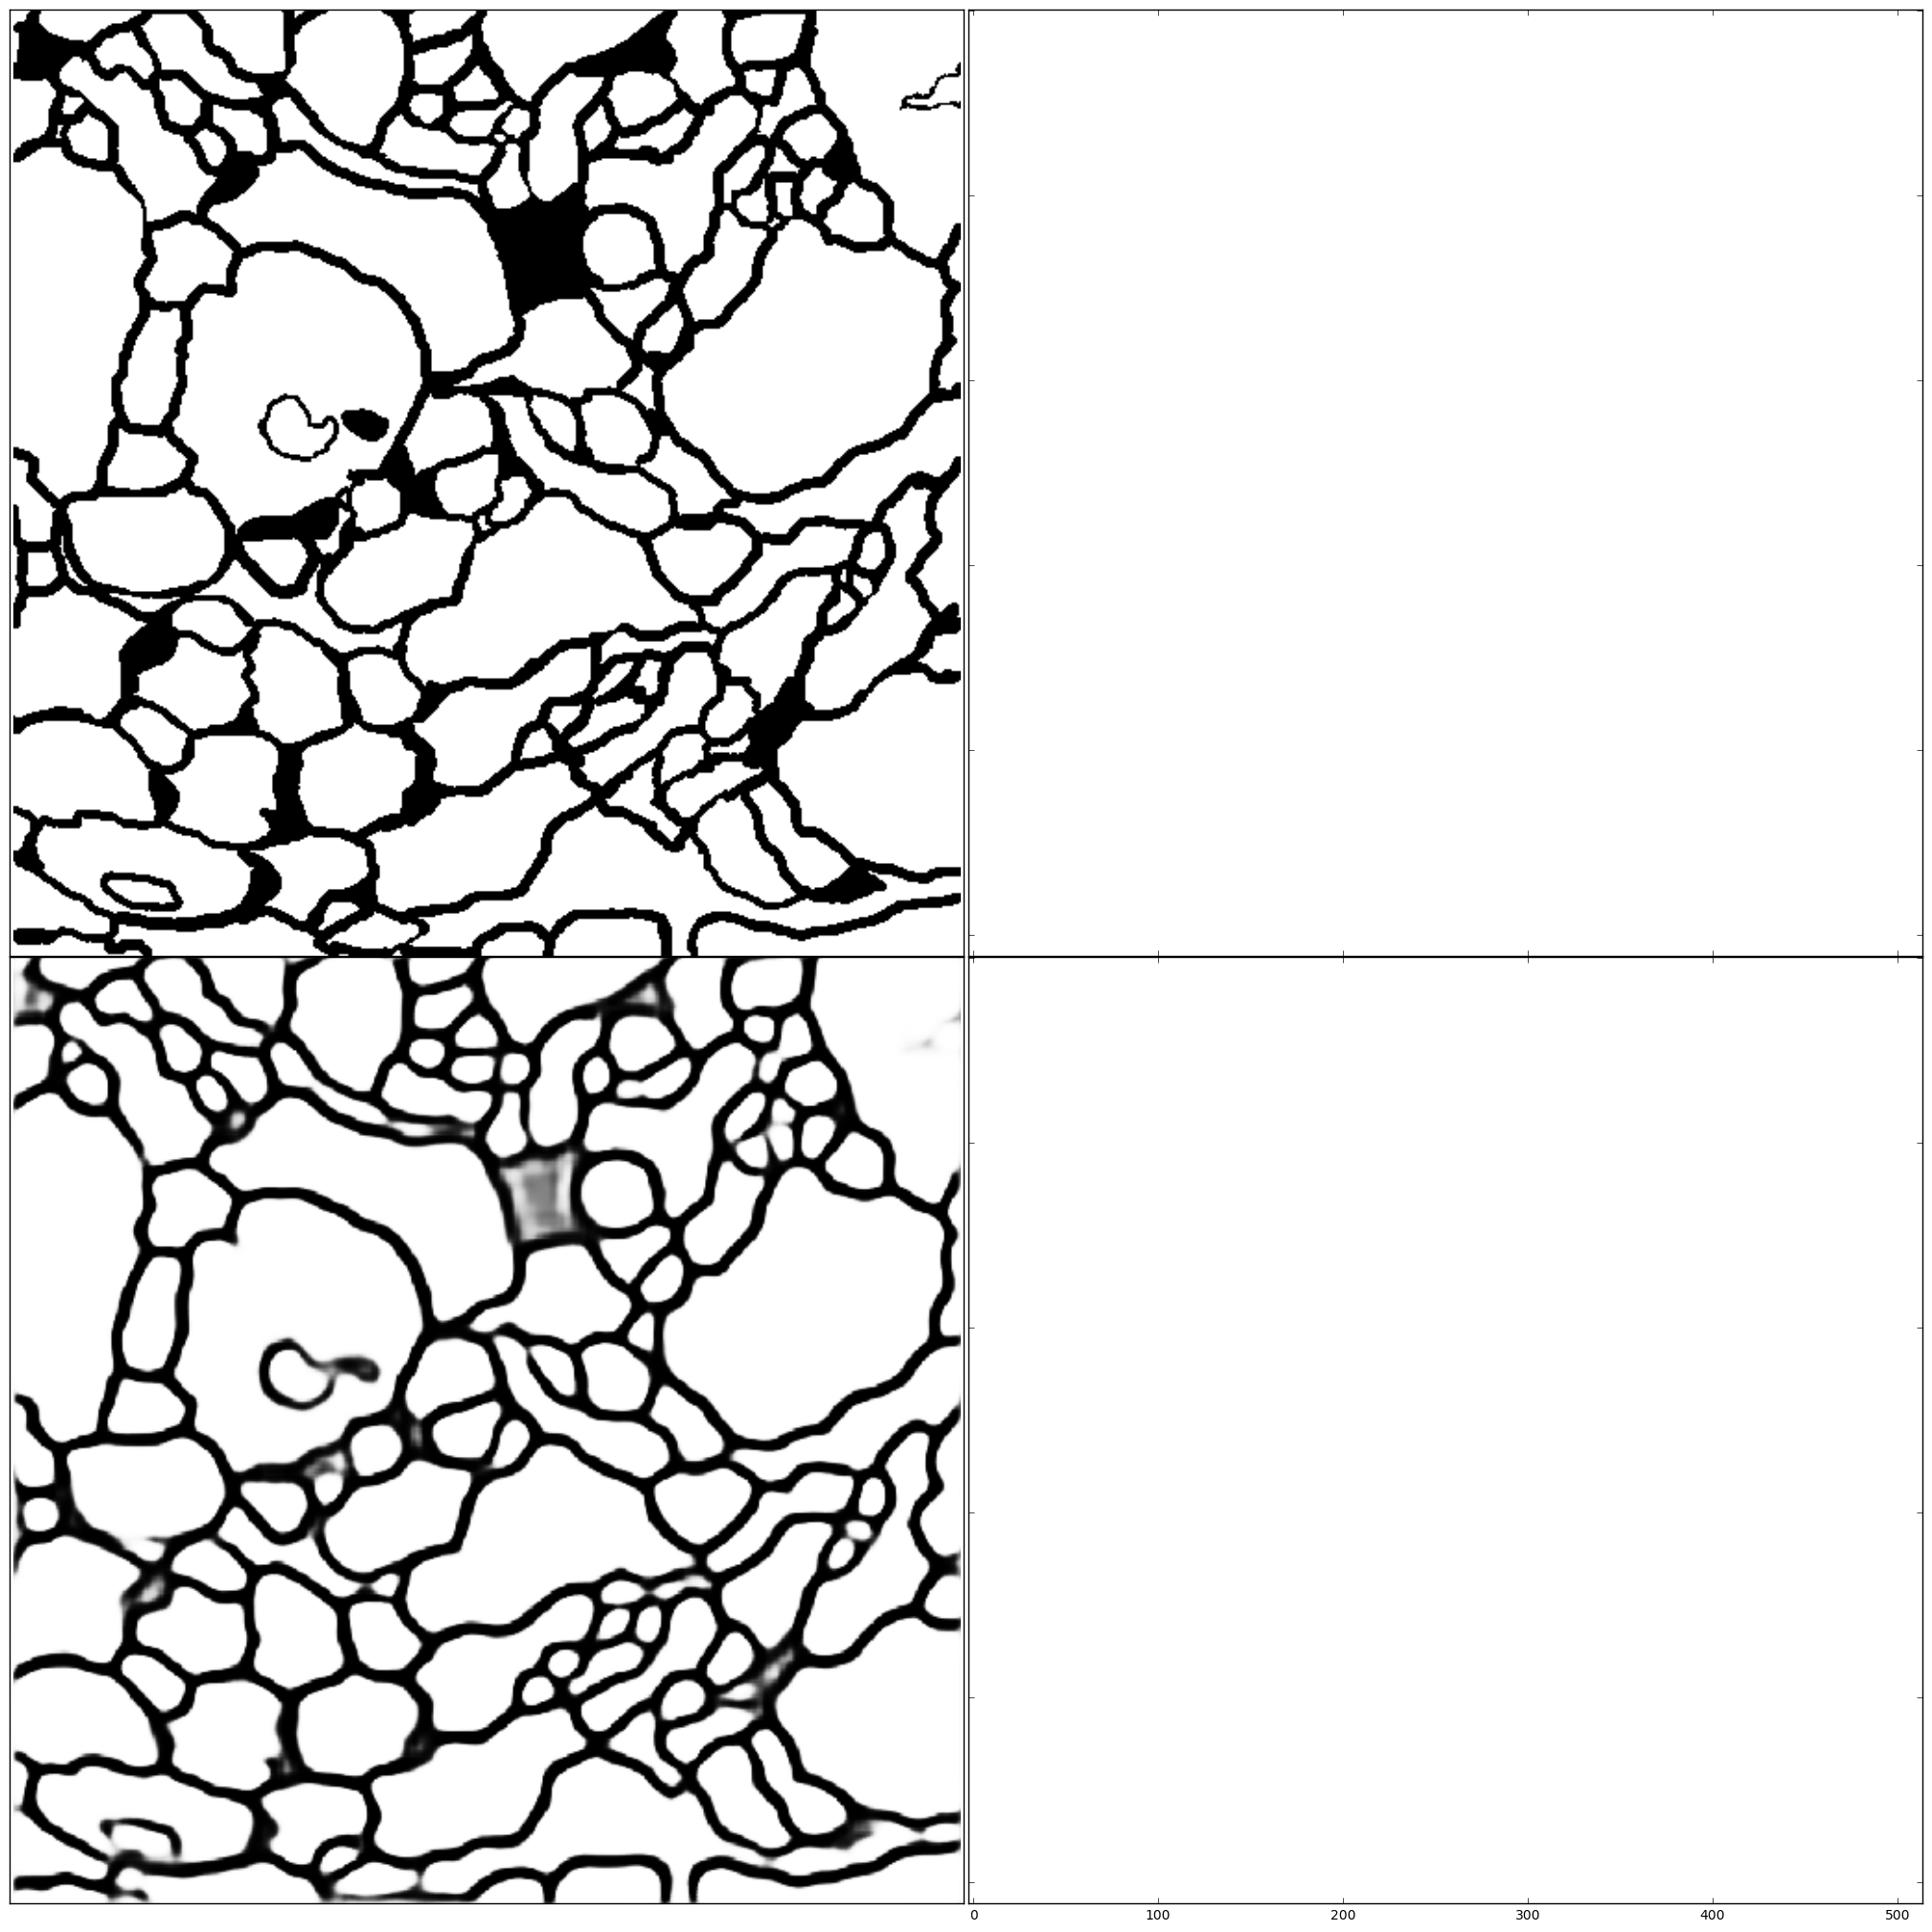

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(20,20))
in_imgs = labels_batches[2]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={x: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((512, 512)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
fig.tight_layout(pad=0.1)

In [14]:
# Terminating the session
sess.close()